In [1]:
import spacy
nlp = spacy.load("it_core_news_sm")

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt


/home/v.acampora/venv2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
###################### carica dataset LDO 20-21 ############################ 

dataLDO2020 = pd.read_excel('/home/a.renda/to_move/LDO/filtrato_per_keyword/20-21_LDO_26K/LDO_20200101_20210101 pulito.ods', engine='odf')
dataLDO2021=pd.read_excel('/home/a.renda/to_move/LDO/filtrato_per_keyword/20-21_LDO_26K/LDO_20210101_20220101 pulito.ods', engine='odf')

In [4]:
# Filtra le righe che non contengono numeri (escludendo anche i NaN)
dataLDO2021 = dataLDO2021[dataLDO2021['nosologico'].astype(str).str.contains(r'\d')]
#rimosse 212 righe

In [5]:
print("\nColumns LDO 20-21:", dataLDO2020.columns)
print("\nColumns LDO 21-22:", dataLDO2021.columns)
print("\nShape LDO 20-21:", dataLDO2020.shape)
print("\nShape LDO 21-22:", dataLDO2021.shape)


Columns LDO 20-21: Index(['nosologico', 'time_inserimento', 'dataInizio', 'dataFine', 'testo',
       'motivo_ricovero', 'anamnesi', 'esameobiettivo', 'terapiafarmaingresso',
       'decorso', 'laboratorio', 'interventi', 'followup', 'terapie2',
       'terapie3', 'esami', 'reparto'],
      dtype='object')

Columns LDO 21-22: Index(['nosologico', 'time_inserimento', 'dataInizio', 'dataFine', 'testo',
       'motivo_ricovero', 'anamnesi', 'esameobiettivo', 'terapiafarmaingresso',
       'decorso', 'laboratorio', 'interventi', 'followup', 'terapie2',
       'terapie3', 'esami', 'reparto'],
      dtype='object')

Shape LDO 20-21: (24123, 17)

Shape LDO 21-22: (39274, 17)


In [6]:
###################### carica database filtrato ################

databaseFiltrato=pd.read_csv('/home/a.renda/to_move/LDO/labeled/20-21_341/DatabaseFiltrato.csv', sep=';')
print(databaseFiltrato.shape)
print(databaseFiltrato.columns) # la prima colonna è solo un contatore

(26237, 3)
Index(['Unnamed: 0', 'nosologico', 'label'], dtype='object')


In [5]:
# Filtra le righe che non contengono numeri (escludendo anche i NaN)
databaseFiltrato = databaseFiltrato[databaseFiltrato['nosologico'].astype(str).str.contains(r'\d')]

#tolte 5 righe

In [6]:
############################ filtra ldo 2020 ######################

# Converti la colonna 'nosologico' del secondo dataset in int
databaseFiltrato['nosologico'] = pd.to_numeric(databaseFiltrato['nosologico'], errors='coerce')

# Trova i nosologici comuni
comuni2020 = dataLDO2020['nosologico'].isin(databaseFiltrato['nosologico'])

# Filtra il primo dataset
dataset_filtrato2020 = dataLDO2020[comuni2020]
print(dataset_filtrato2020.columns)
print(dataset_filtrato2020.shape)

Index(['nosologico', 'time_inserimento', 'dataInizio', 'dataFine', 'testo',
       'motivo_ricovero', 'anamnesi', 'esameobiettivo', 'terapiafarmaingresso',
       'decorso', 'laboratorio', 'interventi', 'followup', 'terapie2',
       'terapie3', 'esami', 'reparto'],
      dtype='object')
(8974, 17)


In [7]:
############################ filtra ldo 2021 ######################

# Trova i nosologici comuni
comuni2021 = dataLDO2021['nosologico'].isin(databaseFiltrato['nosologico'])

# Filtra il primo dataset
dataset_filtrato2021 = dataLDO2021[comuni2021]
print(dataset_filtrato2021.columns)
print(dataset_filtrato2021.shape)

Index(['nosologico', 'time_inserimento', 'dataInizio', 'dataFine', 'testo',
       'motivo_ricovero', 'anamnesi', 'esameobiettivo', 'terapiafarmaingresso',
       'decorso', 'laboratorio', 'interventi', 'followup', 'terapie2',
       'terapie3', 'esami', 'reparto'],
      dtype='object')
(17218, 17)


In [8]:
######################## merge ldo2020 e ldo 2021 filtrati ###################################

merged_dataset = pd.concat([dataset_filtrato2020, dataset_filtrato2021], ignore_index=True) # non ci sono duplicati tra i due dataset 

# Risultato finale
print("\nColumns merged dataset:",merged_dataset.columns)
print("\nShape merged dataset:",merged_dataset.shape)
print(merged_dataset['testo'][0])



Columns merged dataset: Index(['nosologico', 'time_inserimento', 'dataInizio', 'dataFine', 'testo',
       'motivo_ricovero', 'anamnesi', 'esameobiettivo', 'terapiafarmaingresso',
       'decorso', 'laboratorio', 'interventi', 'followup', 'terapie2',
       'terapie3', 'esami', 'reparto'],
      dtype='object')

Shape merged dataset: (26192, 17)
ObesitÃ  di classe III complicata da ipertensione arteriosa, insulino-resistenza con ridotta tolleranza glucidica, epatomegalia steatosica, insufficienza venosa arti inferiori, ipovitaminosi D e ernia iatale,colelitiasi trattata con colecistectomia,regredita a obesitÃ  di classe I dopo intervento chirurgico di bypass gastrico (2011) al peso di 142 Kg con persistenza di ipovitaminosi D, remissione delle comorbiditÃ  e comparsa di ipoglicemia reattiva sintomatica. Micronodulia tiroidea. Anemia microcitica ipocrocromica, sideropenica. Emorroidi congeste del canale anale.Terapia consigliata alla dimissione:Pr: Bariatrifast cpS: 1 cp ore 8.00Pr: Gl

In [9]:
######################## carica dataset con nosologici positivi #####################

Positivi= pd.read_excel('/home/a.renda/to_move/LDO/labeled/20-21_341/NosologiciPositivi_341.xlsx')

In [10]:
################################### aggiungere la colonna positivi #########################################

# Convertire la colonna 'Nosologico' in numerico nel dataset NosologiciPositivi
nosologici_positivi = pd.to_numeric(Positivi['NosologiciPositivi'], errors='coerce').dropna()

# Creare la colonna 'positivi' nel DataFrame merged_dataset
merged_dataset['positivi'] = merged_dataset['nosologico'].isin(nosologici_positivi).astype(int)


# Contare quanti 1 e quanti 0 ci sono nella colonna 'positivi'
count_positivi = merged_dataset['positivi'].value_counts()

# Stampa i risultati
print("\nConteggio dei valori nella colonna 'positivi':")
print(f"Numero di 1 (positivi): {count_positivi.get(1, 0)}")
print(f"Numero di 0 (non positivi): {count_positivi.get(0, 0)}")


Conteggio dei valori nella colonna 'positivi':
Numero di 1 (positivi): 341
Numero di 0 (non positivi): 25851


In [11]:
# Unire parole e numeri in 'reparto' rimuovendo lo spazio e sostituendo con un trattino
merged_dataset['reparto'] = merged_dataset['reparto'].str.replace(r'(\w) (\d)', r'\1-\2', regex=True)

# Visualizza i risultati
print(merged_dataset['reparto'].head())


0    UO Endocrinologia-1
1    UO Endocrinologia-1
2    UO Endocrinologia-1
3    UO Endocrinologia-1
4    UO Endocrinologia-1
Name: reparto, dtype: object


In [12]:
###################### pulisci il testo: risoluzione di errori di codifica, sostituzione caratteri speciali #######################
import ftfy

# Applica ftfy.fix_text() a tutte le colonne di testo nel dataset, gestendo i valori non testuali
for col in merged_dataset.select_dtypes(include='object').columns:
    merged_dataset[col] = merged_dataset[col].apply(lambda x: ftfy.fix_text(x) if isinstance(x, str) else x)


In [13]:
############### Crea testo combinato con tutte le colonne di testo #####################################

# Seleziona le colonne di testo specificate
colonne_testo = ['testo', 'motivo_ricovero', 'anamnesi', 'esameobiettivo',
                  'terapiafarmaingresso', 'decorso', 'laboratorio', 'interventi',
                  'followup', 'terapie2', 'terapie3', 'esami', 'reparto']

# Crea un testo combinato ignorando i NaN
merged_dataset['testo_combinato'] = merged_dataset[colonne_testo].apply(
    lambda row: ' '.join(
        [str(row[col]) for col in colonne_testo if not pd.isna(row[col])]
    ),
    axis=1
)

# Stampa le prime righe per vedere il risultato
print(merged_dataset['testo_combinato'].head())
print(merged_dataset['testo_combinato'][0]) 


0    Obesità di classe III complicata da ipertensio...
1    Carcinoma della tiroide a cellule ossifile (4 ...
2    Carcinoma papillare differenziato della tiroid...
3    gozzo multinodulare con quattro focolai di car...
4    Carcinoma papillare (1,5 cm) variante classica...
Name: testo_combinato, dtype: object
Obesità di classe III complicata da ipertensione arteriosa, insulino-resistenza con ridotta tolleranza glucidica, epatomegalia steatosica, insufficienza venosa arti inferiori, ipovitaminosi D e ernia iatale,colelitiasi trattata con colecistectomia,regredita a obesità di classe I dopo intervento chirurgico di bypass gastrico (2011) al peso di 142 Kg con persistenza di ipovitaminosi D, remissione delle comorbidità e comparsa di ipoglicemia reattiva sintomatica. Micronodulia tiroidea. Anemia microcitica ipocrocromica, sideropenica. Emorroidi congeste del canale anale.Terapia consigliata alla dimissione:Pr: Bariatrifast cpS: 1 cp ore 8.00Pr: Glucobay 50 mg cpS: 1 cp a colazione 1 cp 

In [15]:
####################### MEDIA NUMERO DI PAROLE NELLE COLONNE ###########################

# Funzione per calcolare il numero di parole
def count_words(text):
    if isinstance(text, str):  # Verifica se il testo è una stringa
        return len(text.split())  # Conta le parole
    elif isinstance(text, (int, float)):  # Se è un numero
        return 1  # Considera il numero come una parola
    return 0  # Restituisce 0 se non è una stringa o un numero


# Calcola la lunghezza media in parole per ciascuna colonna di testo
for colonna in colonne_testo:
    word_counts = merged_dataset[colonna].apply(count_words)  # Conta le parole in ogni stringa
    average_word_count = word_counts.mean()  # Calcola la lunghezza media
    print(f"Lunghezza media della colonna '{colonna}' in parole: {average_word_count:.2f}")

# Calcola la lunghezza media in parole della colonna di testo combinato
word_counts_combined = merged_dataset['testo_combinato'].apply(count_words)  # Conta le parole in ogni stringa
average_word_count_combined = word_counts_combined.mean()  # Calcola la lunghezza media
print(f"Lunghezza media della colonna 'testo_combinato' in parole: {average_word_count_combined:.2f}")

Lunghezza media della colonna 'testo' in parole: 26.62
Lunghezza media della colonna 'motivo_ricovero' in parole: 13.00
Lunghezza media della colonna 'anamnesi' in parole: 277.10
Lunghezza media della colonna 'esameobiettivo' in parole: 47.00
Lunghezza media della colonna 'terapiafarmaingresso' in parole: 18.18
Lunghezza media della colonna 'decorso' in parole: 233.98
Lunghezza media della colonna 'laboratorio' in parole: 182.96
Lunghezza media della colonna 'interventi' in parole: 65.72
Lunghezza media della colonna 'followup' in parole: 125.41
Lunghezza media della colonna 'terapie2' in parole: 3.55
Lunghezza media della colonna 'terapie3' in parole: 49.64
Lunghezza media della colonna 'esami' in parole: 21.96
Lunghezza media della colonna 'reparto' in parole: 3.58
Lunghezza media della colonna 'testo_combinato' in parole: 1064.90


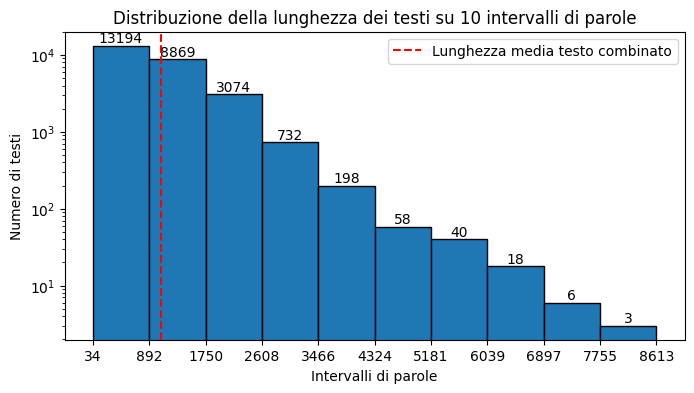

Lunghezza massima testo_combinato (in parole): 8613
Lunghezza minima testo_combinato (in parole): 34


In [16]:
############################# ISTOGRAMMA LUNGHEZZA TESTO COMBINATO  ############################

import matplotlib.pyplot as plt

# Calcola la lunghezza del testo combinato
word_counts_combined = merged_dataset['testo_combinato'].apply(count_words)

# Calcola i valori minimi e massimi
lunghezza_min = word_counts_combined.min()
lunghezza_max = word_counts_combined.max()

# Definisce il numero di bin
num_bin = 10

# Calcola la larghezza delle bin
bin_width = (lunghezza_max - lunghezza_min) / num_bin

# Crea una lista di bin
bins = [lunghezza_min + i * bin_width for i in range(num_bin + 1)]

# Crea la figura più larga
plt.figure(figsize=(8, 4))

# Calcola l'istogramma e i valori delle altezze (n) e dei bin
n, bins, patches = plt.hist(
    word_counts_combined,  # Usa i conteggi delle parole già calcolati
    bins=bins,
    edgecolor='black'
)

# Applica la scala logaritmica sull'asse y
plt.yscale('log')

# Calcola e aggiungi la linea della lunghezza media del testo combinato
average_word_count_combined = word_counts_combined.mean()  # Questo ora è un valore scalare
plt.axvline(x=average_word_count_combined, color='red', linestyle='--', label='Lunghezza media testo combinato')

# Aggiunge il titolo e le etichette degli assi
plt.title('Distribuzione della lunghezza dei testi su 10 intervalli di parole')
plt.xlabel('Intervalli di parole')
plt.ylabel('Numero di testi')

# Mostra le etichette delle bin
plt.xticks(bins)

# Aggiunge una label con il valore sopra ogni barra
for i in range(len(n)):
    plt.text(bins[i] + bin_width / 2, n[i], str(int(n[i])), ha='center', va='bottom')

# Mostra la legenda
plt.legend()

# Mostra il grafico
plt.show()

# Stampa i valori minimi e massimi del testo combinato
print(f"Lunghezza massima testo_combinato (in parole): {lunghezza_max}")
print(f"Lunghezza minima testo_combinato (in parole): {lunghezza_min}")


In [17]:
################# DIMENSIONE VOCABOLARIO ###########################

# Calcola il vocabolario dalla colonna 'testo_combinato_preprocessed'
vocab_set = set()
for testo in merged_dataset['testo_combinato']:
    if isinstance(testo, str):  # Assicurati che il testo non sia NaN
        vocab_set.update(testo.split())

# Calcola la dimensione del vocabolario
vocabolario_dimensione = len(vocab_set)
print(f"Dimensione del vocabolario: {vocabolario_dimensione}")

Dimensione del vocabolario: 1089237


In [ ]:
########################## PRE-PROCESSING VECCHIO ##########################

import spacy
import pandas as pd
import re

# Carica il modello SpaCy per l'italiano
nlp = spacy.load("it_core_news_sm", disable=["parser", "ner"])

# Funzione per pulire i token
def clean_token(token):
    # Rimuove qualsiasi carattere che non sia una lettera o un numero
    cleaned_token = re.sub(r'[^a-zA-Z0-9]', '', token)  

    # Scarta il token se è composto solo da un carattere o solo da un singolo numero
    return '' if len(cleaned_token) == 1 else cleaned_token

# Funzione per tokenizzare e preprocessare
def preprocess_text(row):
    if not isinstance(row, str):  # Verifica che row sia una stringa
        return ""  # Restituisce una stringa vuota se non è valida (ovvero quando vede un nan restiruisce una stringa vuota)
    
    # Rimuove date nel formato 'dd/mm/yyyy' e 'dd/mm/yy'
    row = re.sub(r'\d{1,2}/\d{1,2}/\d{2,4}', '', row)
    row = re.sub(r'\d{1,2}/\d{1,2}', '', row)  # Rimuove numeri separati da /

    # Tokenizza il testo con SpaCy
    doc = nlp(row)
    
    # Filtra stopwords e punteggiatura
    tokens_puliti = [
        clean_token(token.lemma_.lower())  # Lemmatizza, porta a minuscolo e pulisce il token
        for token in doc
        if not token.is_punct and not token.is_stop 
    ]
    
    # Ricombina i token in una stringa
    return " ".join(tokens_puliti)

# Applica il preprocessing solo alle prime 100 righe della colonna 'testo_combinato'
merged_dataset['testo_combinato_preprocessed'] = merged_dataset['testo_combinato'].apply(preprocess_text)

# Visualizza i risultati per le prime 100 righe
print(merged_dataset[['testo_combinato', 'testo_combinato_preprocessed']])


                                         testo_combinato  \
0      Obesità di classe III complicata da ipertensio...   
1      Carcinoma della tiroide a cellule ossifile (4 ...   
2      Carcinoma papillare differenziato della tiroid...   
3      gozzo multinodulare con quattro focolai di car...   
4      Carcinoma papillare (1,5 cm) variante classica...   
...                                                  ...   
26187  Cistopessi fasciale in paziente con cistocele ...   
26188  Polipectomia resettoscopica, miomectomia reset...   
26189  Laparoscopia, isterectomia sovracervicale, ann...   
26190  Polipectomia resettoscopica in paziente con po...   
26191  Mioma sottomucoso Miomectomia resettoscopica I...   

                            testo_combinato_preprocessed  
0      obesit classe iii complicare ipertensione arte...  
1      carcinoma tiroide cellula ossifile  cm ampiame...  
2      carcinoma papillare differenziato tiroide   cm...  
3      gozzo multinodulare focolaio carcino

In [ ]:
########################## PRE-PROCESSING vecchio ##########################

import spacy
import pandas as pd
import re

# Carica il modello SpaCy per l'italiano
nlp = spacy.load("it_core_news_sm", disable=["parser", "ner"])

# Funzione per pulire i token
def clean_token(token):

    # Rimuovi numeri con virgola
    if re.match(r'^\d{1,3}(?:,\d{1,3})$', token):
        return ''  # Scarta il token

    # Mantieni numeri, lettere, rimuovendo altri caratteri speciali
    cleaned_token = re.sub(r'[^a-zA-Z0-9]', '', token) 

    # Scarta il token se è composto solo da un carattere o solo da un numero
    if re.match(r'^\d+$', cleaned_token):  # Se è solo un numero, scartalo
        return ''
    return '' if len(cleaned_token) == 1 else cleaned_token

# Funzione per tokenizzare e preprocessare
def preprocess_text(row):
    if not isinstance(row, str):  # Verifica che row sia una stringa
        return ""  # Restituisce una stringa vuota se non è valida (ovvero quando vede un nan restiruisce una stringa vuota)
    
    # Rimuove date nel formato 'dd/mm/yyyy' e 'dd/mm/yy'
    row = re.sub(r'\d{1,2}/\d{1,2}/\d{2,4}', '', row)
    row = re.sub(r'\d{1,2}/\d{1,2}', '', row)  # Rimuove numeri separati da /

    # Gestisci i punti tra le parole (ad esempio "v.analisi" diventa "v analisi")
    row = re.sub(r'(\w)\.(\w)', r'\1 \2', row)  # Aggiunge uno spazio tra parole separate da punto

        
    # Tokenizza il testo con SpaCy
    doc = nlp(row)
    
    # Filtra stopwords e punteggiatura
    tokens_puliti = [
        clean_token(token.lemma_.lower())  # Lemmatizza, porta a minuscolo e pulisce il token
        for token in doc
        if not token.is_punct and not token.is_stop 
    ]
    
    # Ricombina i token in una stringa
    return " ".join(tokens_puliti)

# Applica il preprocessing della colonna 'testo_combinato'
merged_dataset['testo_combinato_preprocessed'] = merged_dataset['testo_combinato'].apply(preprocess_text)

# Visualizza i risultati per le prime righe
print(merged_dataset[['testo_combinato', 'testo_combinato_preprocessed']].head(10))

# Visualizza i risultati 
print(merged_dataset[['testo_combinato', 'testo_combinato_preprocessed']])


                                     testo_combinato  \
0  Obesità di classe III complicata da ipertensio...   
1  Carcinoma della tiroide a cellule ossifile (4 ...   
2  Carcinoma papillare differenziato della tiroid...   
3  gozzo multinodulare con quattro focolai di car...   
4  Carcinoma papillare (1,5 cm) variante classica...   
5  Carcinoma papillare della tiroide (7 mm) multi...   
6  Carcinoma scarsamente differenziato (9,5 cm) i...   
7  Obesità di III complicata da epatomegalia stea...   
8  Malattia di Cushing da microadenoma ACTH secer...   
9  Gozzo multinodulare non tossico con nodulo dom...   

                        testo_combinato_preprocessed  
0  obesit classe iii complicare ipertensione arte...  
1  carcinoma tiroide cellula ossifile  cm ampiame...  
2  carcinoma papillare differenziato tiroide   cm...  
3  gozzo multinodulare focolaio carcinoma tiroide...  
4  carcinoma papillare  cm variare classico aspet...  
5  carcinoma papillare tiroide  mm multifocale bi... 

In [14]:
####################################### PRE PROCESSING NUOVO di word2vec ################
import spacy
import pandas as pd
import re

# Carica il modello SpaCy per l'italiano
nlp = spacy.load("it_core_news_lg", disable=["parser", "ner"])

def clean_token(token):

    # Rimuovi caratteri non alfanumerici (inclusi simboli, punteggiatura, numeri, ecc.) e sostituiscili con uno spazio
    cleaned_token = re.sub(r'[^a-zA-ZàèéìòùÀÈÉÌÒÙ]', ' ', token)
    cleaned_token = re.sub(r'\s+', ' ', cleaned_token).strip()  # Normalizza gli spazi multipli

    return cleaned_token

    
# Funzione per tokenizzare e preprocessare il testo
def preprocess_text(row):
    if not isinstance(row, str):  # Verifica che il dato sia una stringa valida
        return ""  # Restituisce una stringa vuota se non valido
    
    # Rimuove date nel formato 'dd/mm/yyyy' e 'dd/mm/yy'
    row = re.sub(r'\d{1,2}/\d{1,2}/\d{2,4}', '', row)
    row = re.sub(r'\d{1,2}/\d{1,2}', '', row)  # Rimuove numeri separati da /
      
    # Aggiunge spazi tra numeri e lettere (es. "800duloxetina" -> "800 duloxetina")
    row = re.sub(r'(\d+)([a-zA-Z]+)', r'\1 \2', row)
    row = re.sub(r'([a-zA-Z]+)(\d+)', r'\1 \2', row)

    # Aggiunge spazi tra parole composte tipo "vediAllegato" -> "vedi Allegato"
    row = re.sub(r'([a-zàèéìòù])([A-ZÀÈÉÌÒÙ])', r'\1 \2', row)

    # normalizza  spazi (se ci sono più spazi consecutivi, vengono ridotti a uno solo) e rimuove  spazi all'inizio e alla fine della stringa
    row = re.sub(r'[^\w\s]', ' ', row)  # Rimuove caratteri non alfanumerici e parentesi

    doc = nlp(row)
   
    # Filtra e normalizza i token
    tokens_puliti = [
        clean_token(token.lemma_.lower())
        for token in doc
        if not token.is_punct and not token.is_stop and len(token.text) > 1 #and token.text.isalpha() 
    ]

    
    # Applica un filtro finale per rimuovere manualmente le lettere singole
    tokens_puliti = [token for token in tokens_puliti if len(token) > 1]  # Assicura che tutte le parole siano > 1 carattere
    

    # Ricombina i token in una stringa
    return " ".join(tokens_puliti)

# Applica il preprocessing della colonna 'testo_combinato'
merged_dataset['testo_combinato_preprocessed'] = merged_dataset['testo_combinato'].apply(preprocess_text)

# Applica il preprocessing solo alle prime 100 righe
#merged_dataset['testo_combinato_preprocessed'] = ""
#merged_dataset.loc[:199, 'testo_combinato_preprocessed'] = merged_dataset.loc[:199, 'testo_combinato'].apply(preprocess_text)

# Visualizza i risultati per le prime righe
print(merged_dataset[['testo_combinato', 'testo_combinato_preprocessed']].head(10))


                                     testo_combinato  \
0  Obesità di classe III complicata da ipertensio...   
1  Carcinoma della tiroide a cellule ossifile (4 ...   
2  Carcinoma papillare differenziato della tiroid...   
3  gozzo multinodulare con quattro focolai di car...   
4  Carcinoma papillare (1,5 cm) variante classica...   
5  Carcinoma papillare della tiroide (7 mm) multi...   
6  Carcinoma scarsamente differenziato (9,5 cm) i...   
7  Obesità di III complicata da epatomegalia stea...   
8  Malattia di Cushing da microadenoma ACTH secer...   
9  Gozzo multinodulare non tossico con nodulo dom...   

                        testo_combinato_preprocessed  
0  obesità classe iii complicare ipertensione art...  
1  carcinoma tiroide cellula ossifile cm ampiamen...  
2  carcinoma papillare differenziare tiroide cm l...  
3  gozzo multinodulare focolaio carcinoma tiroide...  
4  carcinoma papillare cm variante classico aspet...  
5  carcinoma papillare tiroide mm multifocale bil... 

In [15]:
############################### MEDIA NUMERO DI PAROLE TESTO PRE PROCESSATO ###########################

# Funzione per calcolare il numero di parole
def count_words(text):
    if isinstance(text, str):  # Verifica se il testo è una stringa
        return len(text.split())  # Conta le parole
    elif isinstance(text, (int, float)):  # Se è un numero
        return 1  # Considera il numero come una parola
    return 0  # Restituisce 0 se non è una stringa o un numero

# Calcola la lunghezza media in parole della colonna di testo combinato
word_counts_combined = merged_dataset['testo_combinato_preprocessed'].apply(count_words)  # Conta le parole in ogni stringa
average_word_count_combined = word_counts_combined.mean()  # Calcola la lunghezza media
print(f"Lunghezza media della colonna 'testo_combinato' preprocessato in parole: {average_word_count_combined:.2f}")

Lunghezza media della colonna 'testo_combinato' preprocessato in parole: 683.29


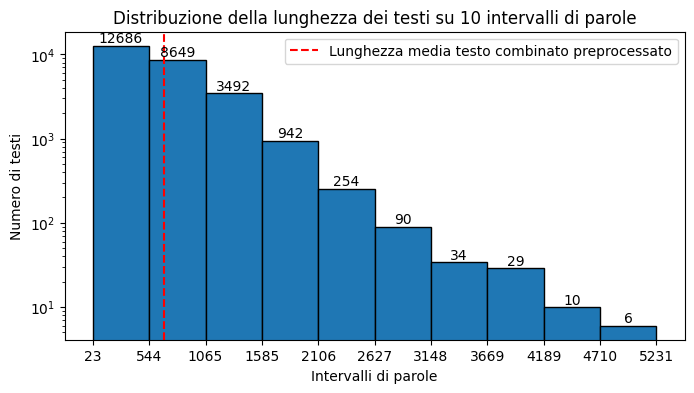

Lunghezza massima testo_combinato preprocessato (in parole): 5231
Lunghezza minima testo_combinato preprocessato (in parole): 23


In [16]:
############################ ISTOGRAMMA LUNGHEZZA TESTO CMBINATO PRE-PROCESSATO #############################

import matplotlib.pyplot as plt

# Calcola la lunghezza del testo combinato
word_counts_combined = merged_dataset['testo_combinato_preprocessed'].apply(count_words)

# Calcola i valori minimi e massimi
lunghezza_min = word_counts_combined.min()
lunghezza_max = word_counts_combined.max()

# Definisce il numero di bin
num_bin = 10

# Calcola la larghezza delle bin
bin_width = (lunghezza_max - lunghezza_min) / num_bin

# Crea una lista di bin
bins = [lunghezza_min + i * bin_width for i in range(num_bin + 1)]

# Crea la figura più larga
plt.figure(figsize=(8, 4))

# Calcola l'istogramma e i valori delle altezze (n) e dei bin
n, bins, patches = plt.hist(
    word_counts_combined,  # Usa i conteggi delle parole già calcolati
    bins=bins,
    edgecolor='black'
)

# Applica la scala logaritmica sull'asse y
plt.yscale('log')

# Calcola e aggiungi la linea della lunghezza media del testo combinato
average_word_count_combined = word_counts_combined.mean()  # Questo ora è un valore scalare
plt.axvline(x=average_word_count_combined, color='red', linestyle='--', label='Lunghezza media testo combinato preprocessato')

# Aggiunge il titolo e le etichette degli assi
plt.title('Distribuzione della lunghezza dei testi su 10 intervalli di parole')
plt.xlabel('Intervalli di parole')
plt.ylabel('Numero di testi')

# Mostra le etichette delle bin
plt.xticks(bins)

# Aggiunge una label con il valore sopra ogni barra
for i in range(len(n)):
    plt.text(bins[i] + bin_width / 2, n[i], str(int(n[i])), ha='center', va='bottom')

# Mostra la legenda
plt.legend()

# Mostra il grafico
plt.show()

# Stampa i valori minimi e massimi del testo combinato
print(f"Lunghezza massima testo_combinato preprocessato (in parole): {lunghezza_max}")
print(f"Lunghezza minima testo_combinato preprocessato (in parole): {lunghezza_min}")


In [20]:
print(merged_dataset['testo_combinato'][2])
print(merged_dataset['testo_combinato_preprocessed'][2])

Carcinoma papillare differenziato della tiroide (>4cm, lobo sinistro), variante classica, multifocale, bilaterale, limitato alla ghiandola (T3amN1Mx) associato a tiroidite linfocitaria trattato con  tiroidectomia totale  ed asportazione parziale dei linfonodi del comparto centrale (Pisa, San Rossore. Prof Galleri) e terapia radiometabolica con 131-I a scopo adiuvante (Pisa) Terapia radiometabolica con 131-I a scopo adiuvante Carcinoma papillare differenziato della tiroide (>4cm, lobo sinistro), variante classica, multifocale, bilaterale, limitato alla ghiandola (T3amN1Mx) associato a tiroidite linfocitaria trattato con  tiroidectomia totale  ed asportazione parziale dei linfonodi del comparto centrale (Pisa, San Rossore. Prof Galleri) Terapia radiometabolica con 131-I a scopo adiuvante Abbiamo programmato una visita endocrinologica (1° controllo post-ablazione, Ospedale Cisanello, Edificio 8) in regime Ambulatoriale in data 09/07/2020. Occorreranno le impegnative per 1) prelievo ematic

In [18]:
####################### DIMENSIONE VOCABOLARIO PRE-PROCESSATO ######################

from sklearn.feature_extraction.text import TfidfVectorizer

# Calcola il vocabolario dalla colonna 'testo_combinato_preprocessed'
vocab_set = set()
for testo in merged_dataset['testo_combinato_preprocessed']:
    if isinstance(testo, str):  # Assicurati che il testo non sia NaN
        vocab_set.update(testo.split())

# Calcola la dimensione del vocabolario
vocabolario_dimensione = len(vocab_set)

# Vettorizzazione usando TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Filtra i NaN e vettorizza le prime 200 righe di 'testo_combinato_preprocessed'
valid_texts = merged_dataset['testo_combinato_preprocessed'].dropna() # Rimuove i NaN
tfidf_matrix = tfidf_vectorizer.fit_transform(valid_texts)

# Numero di features (parole) nella matrice TF-IDF
num_features = tfidf_matrix.shape[1]

# Confronto tra dimensione del vocabolario e numero di features
print("Dimensione del vocabolario:", vocabolario_dimensione)
print("Numero di features nella matrice TF-IDF:", num_features)

# Verifica dell'uguaglianza
if vocabolario_dimensione == num_features:
    print("La dimensione del vocabolario coincide con il numero di features nella matrice TF-IDF.")
else:
    print("La dimensione del vocabolario NON coincide con il numero di features nella matrice TF-IDF.")


Dimensione del vocabolario: 129726
Numero di features nella matrice TF-IDF: 129716
La dimensione del vocabolario NON coincide con il numero di features nella matrice TF-IDF.


In [19]:
# Ottieni il vocabolario dal TfidfVectorizer
vectorizer_vocab = set(tfidf_vectorizer.get_feature_names_out())

# Parole nel tuo vocabolario che non sono nel vocabolario del TfidfVectorizer
missing_in_tfidf = vocab_set - vectorizer_vocab

# Parole nel vocabolario del TfidfVectorizer che non sono nel tuo vocabolario
extra_in_tfidf = vectorizer_vocab - vocab_set

# Stampa le parole mancanti e extra
print("Parole presenti nel vocabolario manuale ma non nel vocabolario del TF-IDF:")
print(missing_in_tfidf)

print("\nParole presenti nel vocabolario del TF-IDF ma non nel vocabolario manuale:")
print(extra_in_tfidf)

# Puoi anche stampare il numero di parole mancanti ed extra
print("\nNumero di parole mancanti:", len(missing_in_tfidf))
print("Numero di parole extra:", len(extra_in_tfidf))

Parole presenti nel vocabolario manuale ma non nel vocabolario del TF-IDF:
{'i', 's', 'v', 'd', 'f', 't', 'p', 'g', 'l', 'a'}

Parole presenti nel vocabolario del TF-IDF ma non nel vocabolario manuale:
set()

Numero di parole mancanti: 10
Numero di parole extra: 0


In [23]:
#######################################################################################

In [24]:
!pip install xgboost



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [15]:
########################## CLASSIFIERS #################

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier


# Definisci una lista di classificatori che vuoi provare
classifiers = {
    'RandomForest': RandomForestClassifier(n_jobs=-1, max_depth=10, max_features=0.1, random_state=42),
    #'RandomForest': RandomForestClassifier(n_jobs=-1, max_depth=10, random_state=42),
    #'LogisticRegression': LogisticRegression(random_state=42, max_iter=200),
    #'SVM': SVC(probability=True,random_state=42),
    #'KNeighbors': KNeighborsClassifier(),
    #'DecisionTree': DecisionTreeClassifier(max_depth=10, random_state=42),
    #'DecisionTree': DecisionTreeClassifier(max_depth=20, random_state=42),
    #'GradientBoosting': GradientBoostingClassifier(learning_rate=0.01, max_depth=6, random_state=42),
    #'extremeGradientBoosting': XGBClassifier( learning_rate=0.1, random_state=42, n_jobs=-1, max_depth=6),
    #'mlp': MLPClassifier(hidden_layer_sizes=(50,), activation='relu', solver='adam', max_iter=200, alpha=0.0001, learning_rate_init=0.01, batch_size=256, early_stopping=True),

}

In [ ]:
######################################################################

In [ ]:
############################### weighted TFIDF VECTORIZER ############################

from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

class Wcbtfidf(BaseEstimator, TransformerMixin):
    def __init__(self, max_features, custom_weights=None):  
        self.max_features = max_features
        self.custom_weights = custom_weights  
        self.combine_vocab = []
        self.class_wise_vocab = {}
        self.final_tfidf = None

    def fit(self, X, y):
        if not isinstance(y, pd.Series):
            y = pd.Series(y)

        if not isinstance(X, pd.Series):
            X = pd.Series(X)

        if self.custom_weights is None:
            self.custom_weights = y.value_counts(normalize=True).to_dict()
            total = 0
            weights = {}
            
            for key, val in self.custom_weights.items():
                weight = int(np.floor(val * self.max_features))  
                weights[key] = weight
                total += weight

            # Distribuisci il resto per bilanciare la somma
            remaining = self.max_features - total
            sorted_labels = sorted(weights.keys(), key=lambda k: y.value_counts()[k], reverse=True)
            for label in sorted_labels[:remaining]:
                weights[label] += 1

            self.custom_weights = weights

        elif len(self.custom_weights.keys()) != y.nunique():
            raise ValueError(
                f"Custom weights keys ({list(self.custom_weights.keys())}) do not match the number of unique labels in y ({y.unique()})."
            )
        elif np.sum(list(self.custom_weights.values())) != self.max_features:
            raise ValueError(
                f"The sum of custom weights ({np.sum(list(self.custom_weights.values()))}) does not match max_features ({self.max_features})."
            )

        # Debugging output 
        print(f"Calcolo automatico pesi: {self.custom_weights}")
        print(f"Somma pesi: {np.sum(list(self.custom_weights.values()))}, max_features: {self.max_features}")
        
        self.combine_vocab = self.return_total_vocab(X, y, self.custom_weights)
        self.final_tfidf = TfidfVectorizer(vocabulary=self.combine_vocab)  # Nessuna lista di stopwords
        self.final_tfidf.fit(X)
        return self

    def transform(self, X):
        if self.final_tfidf is None:
            raise ValueError("The fit method must be called before transform.")
        transformed_data = self.final_tfidf.transform(X)
        return pd.DataFrame(transformed_data.toarray(), columns=self.final_tfidf.get_feature_names_out())

    #def return_total_vocab(self, X, y, label_dict):
        total_vocab = []
        exclude = []  # Initialize an empty list to track excluded words (non-overlapping)
    
        for key, val in label_dict.items():
            if val != 0:
                slice_data = X[y == key]
                tfidf = TfidfVectorizer(max_features=val, stop_words=exclude)
                tfidf.fit(slice_data)
                vocab = list(tfidf.get_feature_names_out())
                total_vocab.extend(vocab)
                exclude.extend(vocab)  # Update the exclude list with features from this class
                self.class_wise_vocab[key] = vocab
            else:
                self.class_wise_vocab[key] = []
    
        return total_vocab
    

    def return_total_vocab(self, X, y, label_dict):
        total_vocab = {}  # Dizionario per il vocabolario finale (parola -> valore TF-IDF)

        # Itera sulle classi e calcola il TF-IDF per ciascuna
        for key, val in label_dict.items():
            if val != 0:
                slice_data = X[y == key]  # Dati della classe corrente
                tfidf = TfidfVectorizer(max_features=val)  # Calcola il TF-IDF senza esclusioni
                tfidf.fit(slice_data)  # Calcola il TF-IDF per questa classe
                
                # Ottieni le parole e i rispettivi valori TF-IDF
                tfidf_matrix = tfidf.transform(slice_data)  # Calcola i valori TF-IDF per slice_data
                feature_names = tfidf.get_feature_names_out()  # Ottieni le parole
                tfidf_values = np.array(tfidf_matrix.sum(axis=0)).flatten()  # Somma i valori TF-IDF per ciascuna parola
                
                # Per ogni parola, aggiorna il dizionario con la somma dei valori TF-IDF
                for word, tfidf_value in zip(feature_names, tfidf_values):
                    if word in total_vocab:
                        #total_vocab[word] = max(total_vocab[word], tfidf_value)  # Prendi il massimo
                        total_vocab[word] = (total_vocab[word] + tfidf_value) / 2  # Calcola la media
                    else:
                        total_vocab[word] = tfidf_value  # Aggiungi la parola con il suo valore TF-IDF

                self.class_wise_vocab[key] = list(feature_names)  # Salva il vocabolario per la classe

        # Ordina il vocabolario finale in base al valore di TF-IDF (dal più alto al più basso)
        sorted_vocab = sorted(total_vocab.items(), key=lambda item: item[1], reverse=True)
        
        # Prendi solo i primi 'max_features' vocabolari
        final_vocab = [word for word, value in sorted_vocab[:self.max_features]]
        
        return final_vocab  # Restituisce il vocabolario finale con parole uniche e i loro valori aggregati


In [ ]:
########################### CROSS VALIDATION #########################

from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_predict
import numpy as np


# Funzione modificata per includere la media delle features
def eval_cross_validation(pipeline, X, y, skf):
    list_reports = []
    list_f1 = []
    list_auc = []  # Lista per raccogliere i valori di AUC mediati
    list_num_features = []  # Lista per raccogliere il numero di features per ogni fold
    
    # Crea una lista per raccogliere precision, recall e f1-score mediati
    precision_sum = {}
    recall_sum = {}
    f1_sum = {}
    
    # Liste per la deviazione standard
    precision_values = {}
    recall_values = {}
    f1_values = {}

    # Inizializza il supporto per ogni classe
    unique_labels = y.unique()
    support_sum = {str(label): 0 for label in unique_labels}  # Assicurati che le etichette siano stringhe

    for train, val in skf.split(X, y):
        X_tr = X.values[train]
        y_tr = y.values[train]
        X_val = X.values[val]
        y_val = y.values[val]

        # Addestra il pipeline sul training set
        pipeline.fit(X_tr, y_tr)

        # Previsioni sul validation set
        y_pred = pipeline.predict(X_val)
        y_pred_prob = pipeline.predict_proba(X_val)[:, 1]  # Probabilità della classe positiva

        # Crea il classification report come dizionario
        cr = classification_report(y_val, y_pred, output_dict=True)

        # Aggiungi il report alla lista
        list_reports.append(cr)

        # Estrai il F1-score
        list_f1.append(cr['weighted avg']['f1-score'])

        # Calcola l'AUC per questo fold
        auc_score = roc_auc_score(y_val, y_pred_prob)
        list_auc.append(auc_score)

        # Raccogli il numero di features per questo fold
        X_tfidf = pipeline.named_steps['wcbtfidf'].transform(X_val)
        list_num_features.append(X_tfidf.shape[1])  # Numero di features per questo fold

        # Somma le metriche per ogni classe
        for label, metrics in cr.items():
            if label not in ['accuracy', 'macro avg', 'weighted avg']:
                precision_sum[label] = precision_sum.get(label, 0) + metrics['precision']
                recall_sum[label] = recall_sum.get(label, 0) + metrics['recall']
                f1_sum[label] = f1_sum.get(label, 0) + metrics['f1-score']

                # Aggiungi valori per la deviazione standard
                precision_values[label] = precision_values.get(label, []) + [metrics['precision']]
                recall_values[label] = recall_values.get(label, []) + [metrics['recall']]
                f1_values[label] = f1_values.get(label, []) + [metrics['f1-score']]

                # Somma il supporto per questa fold
                support_sum[str(label)] += metrics['support']  # Usa str(label) per garantire la corrispondenza

    # Calcola la media dell'AUC
    auc_avg = np.mean(list_auc)

    # Calcola la media del numero di features
    num_features_avg = np.mean(list_num_features)

    # Calcola la media delle metriche per ogni classe
    num_folds = skf.get_n_splits()
    precision_avg = {label: precision_sum[label] / num_folds for label in precision_sum}
    recall_avg = {label: recall_sum[label] / num_folds for label in recall_sum}
    f1_avg_per_class = {label: f1_sum[label] / num_folds for label in f1_sum}

    # Calcola la deviazione standard per ogni metrica
    precision_std = {label: np.std(precision_values[label]) for label in precision_values}
    recall_std = {label: np.std(recall_values[label]) for label in recall_values}
    f1_std = {label: np.std(f1_values[label]) for label in f1_values}

    # Calcola il supporto medio per ciascuna classe
    support_avg = {label: support_sum[label] / num_folds for label in support_sum}

    # Crea un DataFrame per visualizzare le metriche
    df_avg = pd.DataFrame({
        'Precision': precision_avg,
        'Recall': recall_avg,
        'F1-Score': f1_avg_per_class,
        'Precision Std': precision_std,
        'Recall Std': recall_std,
        'F1-Score Std': f1_std,
        'Support': support_avg,  # Supporto medio
        'Avg Features': num_features_avg,  # Media delle features
    })  # Trasponi per avere le classi come righe

    return df_avg, auc_avg, f1_avg_per_class, num_features_avg 

# Crea un oggetto StratifiedKFold per la cross-validation stratificata
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


### Modello: RandomForest ###
Calcolo automatico pesi: {0: 4935, 1: 65}
Somma pesi: 5000, max_features: 5000
Calcolo automatico pesi: {0: 4935, 1: 65}
Somma pesi: 5000, max_features: 5000
Calcolo automatico pesi: {0: 4935, 1: 65}
Somma pesi: 5000, max_features: 5000
Calcolo automatico pesi: {0: 4935, 1: 65}
Somma pesi: 5000, max_features: 5000
Calcolo automatico pesi: {0: 4935, 1: 65}
Somma pesi: 5000, max_features: 5000
Calcolo automatico pesi: {0: 4935, 1: 65}
Somma pesi: 5000, max_features: 5000
Calcolo automatico pesi: {0: 4935, 1: 65}
Somma pesi: 5000, max_features: 5000
Calcolo automatico pesi: {0: 4935, 1: 65}
Somma pesi: 5000, max_features: 5000
Calcolo automatico pesi: {0: 4935, 1: 65}
Somma pesi: 5000, max_features: 5000
Calcolo automatico pesi: {0: 4935, 1: 65}
Somma pesi: 5000, max_features: 5000
Classification report mediato:
   Precision    Recall  F1-Score  Precision Std  Recall Std  F1-Score Std  \
0   0.995166  0.963328  0.978984       0.001158    0.003851      0.0020

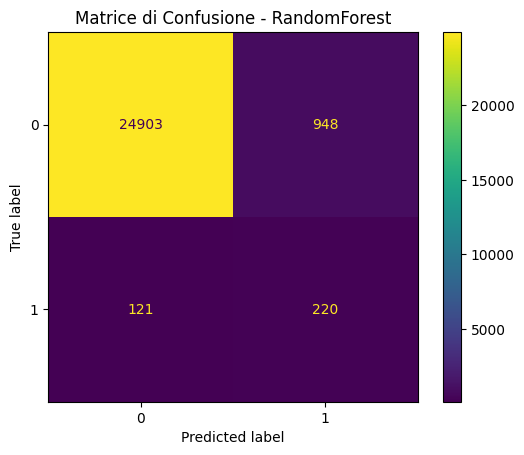

In [39]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from imblearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


X = merged_dataset['testo_combinato_preprocessed'].fillna("")  # Riempie eventuali NaN con stringhe vuote
y = merged_dataset['positivi']

# Loop per ogni classificatore
for clf_name, clf in classifiers.items():
    print(f"\n### Modello: {clf_name} ###")
    
    # Configura il pipeline con Wcbtfidf e il classificatore
    pipeline = Pipeline([
        ('wcbtfidf', Wcbtfidf(max_features=5000)),  # Imposta max_features; verifica se è sufficiente per il dataset
        #('smote', SMOTE(random_state=42)),
        ('smote', SMOTE(random_state=42, sampling_strategy= 0.1 )),  # Applica SMOTE prima per la classe minoritaria
        ('undersample', RandomUnderSampler(sampling_strategy= 'auto', random_state=42)),  # Poi undersampling della classe maggioritaria
        ('classificazione', clf)
    ])

    # Esegui la cross-validation
    df_avg, auc_avg, f1_avg_per_class, num_features_avg = eval_cross_validation(pipeline, X, y, skf)

    # Stampa i risultati
    print("Classification report mediato:")
    print(df_avg)
    print(f"AUC medio: {auc_avg:.4f}")
    print(f"Numero medio di features: {num_features_avg:.2f}")
    
    # Previsioni su tutto il dataset usando cross_val_predict
    y_pred = cross_val_predict(pipeline, X, y, cv=skf)

    # Visualizza la matrice di confusione
    ConfusionMatrixDisplay.from_predictions(y, y_pred)
    plt.title(f"Matrice di Confusione - {clf_name}")
    plt.show()


In [ ]:
##################################################### APPROCCI DEL PAPER SU TFIDF ###########################

In [ ]:
############################### TFIDF ICF VECTORIZER ############################

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from scipy.sparse import csr_matrix

class TfidfIcfVectorizer(TfidfVectorizer):
    def fit_transform(self, X, y):
        tfidf_matrix = super().fit_transform(X)
        self.icf_weights = self._compute_icf_weights(tfidf_matrix, y)
        return tfidf_matrix.multiply(self.icf_weights)

    def _compute_icf_weights(self, tfidf_matrix, y):
        # Numero totale di documenti
        N = tfidf_matrix.shape[0]

        # Matrice booleana: 1 se un termine è presente nel documento
        term_presence = (tfidf_matrix > 0).astype(int)

        # Calcolo del numero di documenti per classe
        classes, class_counts = np.unique(y, return_counts=True)

        # Array per memorizzare i pesi ICF
        icf_weights = np.zeros((tfidf_matrix.shape[1], len(classes)))

        for idx, class_label in enumerate(classes):
            class_mask = (y == class_label)
            term_docs_in_class = term_presence[class_mask].sum(axis=0)

            # Calcolo ICF con smoothing, bilanciando l'effetto delle classi
            icf_weights[:, idx] = np.log((N + 1) / (1 + term_docs_in_class)).A1

        # Media ponderata dei pesi ICF su tutte le classi, usando la dimensione della classe come peso
        class_weights = class_counts / N
        weighted_icf = np.average(icf_weights, axis=1, weights=class_weights)
        
        return weighted_icf.reshape(1, -1)


In [ ]:
############################### TFIDF RF VECTORIZER ############################

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

class TfidfRfVectorizer(TfidfVectorizer):
    def fit_transform(self, X, y):
        tf_matrix = super().fit_transform(X)  # Calcola la matrice TF
        rf_weights = self._compute_rf_weights(tf_matrix, y)  # Calcola i pesi RF
        return tf_matrix.multiply(rf_weights)

    def _compute_rf_weights(self, tf_matrix, y):
        # Numero totale di documenti
        N = tf_matrix.shape[0]

        # Trova il numero di documenti in cui un termine è presente per ciascuna classe
        term_presence = (tf_matrix > 0).astype(int)  # matrice booleana
        classes, class_counts = np.unique(y, return_counts=True)

        # Inizializza i pesi RF a 1 (per evitare di avere zero all'inizio)
        rf_weights = np.ones(tf_matrix.shape[1])

        # Calcola i pesi di rilevanza per ogni termine in ogni classe
        for class_idx, class_label in enumerate(classes):
            class_mask = (y == class_label)
            term_docs_in_class = term_presence[class_mask].sum(axis=0)  # Conta i termini nella classe
            term_docs_in_class = np.asarray(term_docs_in_class).flatten()  # Converte in un array piatto

            # Calcola la frequenza di rilevanza per ciascun termine
            rf_weights += term_docs_in_class / class_counts[class_idx]  # Frequenza di rilevanza

        # Assicurati che i pesi siano una matrice con la forma corretta
        return rf_weights.reshape(1, -1)  # Riformatta come una matrice 1 x numero di termini

In [ ]:
############################### TFIDF IGM VECTORIZER ############################

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

class TfidfIgmVectorizer(TfidfVectorizer):
    def __init__(self, lambda_coefficient=7.0, max_features=None):
        super().__init__(max_features=max_features)  # Passa il parametro max_features al TfidfVectorizer
        self.lambda_coefficient = lambda_coefficient

    def fit_transform(self, X, y):
        # Calcola la matrice TF
        tf_matrix = super().fit_transform(X)  # Calcola la matrice TF-IDF
        igm_weights = self._compute_igm_weights(tf_matrix, y)  # Calcola i pesi IGM
        #sqrt_tf_matrix = np.sqrt(tf_matrix.toarray())  # Applica la radice quadrata alla matrice TF
        #return sqrt_tf_matrix * (1 + self.lambda_coefficient + igm_weights)  # Applica la formula
        return tf_matrix.multiply(igm_weights)  # Applica i pesi IGM alla matrice TF
    
    
    def _compute_igm_weights(self, tf_matrix, y):
        # Numero totale di documenti
        N = tf_matrix.shape[0]
        num_features = tf_matrix.shape[1]

        # Trova la frequenza del termine nelle diverse classi
        term_presence = (tf_matrix > 0).astype(int)  # matrice booleana: presenza del termine nei documenti
        classes = np.unique(y)  # Classi uniche e il loro numero

        # Inizializza i pesi IGM a 1 (per evitare divisioni per zero)
        igm_weights = np.ones(num_features)

        # Calcola la frequenza dei termini per ogni classe
        term_docs_in_class = np.zeros((len(classes), num_features))  # matrice di frequenza per classe e termine

        # Per ogni classe, calcoliamo quante volte ogni termine appare nei documenti della classe
        for class_idx, class_label in enumerate(classes):
            class_mask = (y == class_label)  # Maschera per la classe corrente
            term_docs_in_class[class_idx] = term_presence[class_mask].sum(axis=0)  # Somma le occorrenze di termini nella classe

        # Calcola i pesi IGM per ogni termine
        total_term_docs = term_docs_in_class.sum(axis=0)  # Somma delle frequenze dei termini (per tutte le classi)

        # Calcola i pesi IGM usando il termine di rilevanza (senza cicli annidati)
        for class_idx in range(len(classes)):
            class_term_docs = term_docs_in_class[class_idx]
            relevant_term_docs = class_term_docs / total_term_docs  # Rilevanza di ciascun termine

            # Aggiorna i pesi IGM
            igm_weights += self.lambda_coefficient + relevant_term_docs

        # Ritorna i pesi IGM come matrice di forma (1, num_features)
        return igm_weights.reshape(1, -1)


In [20]:
########################### CROSS VALIDATION CON TF-IDF-ICF #########################

from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_predict
import numpy as np

# Funzione modificata per includere la media delle features
def eval_cross_validation(pipeline, X, y, skf):
    list_reports = []
    list_f1 = []
    list_auc = []  # Lista per raccogliere i valori di AUC mediati
    list_num_features = []  # Lista per raccogliere il numero di features per ogni fold
    
    # Crea una lista per raccogliere precision, recall e f1-score mediati
    precision_sum = {}
    recall_sum = {}
    f1_sum = {}
    
    # Liste per la deviazione standard
    precision_values = {}
    recall_values = {}
    f1_values = {}

    # Inizializza il supporto per ogni classe
    unique_labels = y.unique()
    support_sum = {str(label): 0 for label in unique_labels}  # Assicurati che le etichette siano stringhe

    for train, val in skf.split(X, y):
        X_tr = X.iloc[train]  # differenza con 'baseline1'
        y_tr = y.iloc[train]
        X_val = X.iloc[val]
        y_val = y.iloc[val]

        # Addestra il pipeline sul training set
        pipeline.fit(X_tr, y_tr)

        # Previsioni sul validation set
        y_pred = pipeline.predict(X_val)
        y_pred_prob = pipeline.predict_proba(X_val)[:, 1]  # Probabilità della classe positiva

        # Crea il classification report come dizionario
        cr = classification_report(y_val, y_pred, output_dict=True)

        # Aggiungi il report alla lista
        list_reports.append(cr)

        # Estrai il F1-score
        list_f1.append(cr['weighted avg']['f1-score'])

        # Calcola l'AUC per questo fold
        auc_score = roc_auc_score(y_val, y_pred_prob)
        list_auc.append(auc_score)

        # Raccogli il numero di features per questo fold
        X_tfidf = pipeline.named_steps['tfidf_igm'].transform(X_val)  # Modificato per estrarre la trasformazione
        list_num_features.append(X_tfidf.shape[1])  # Numero di features per questo fold

        # Somma le metriche per ogni classe
        for label, metrics in cr.items():
            if label not in ['accuracy', 'macro avg', 'weighted avg']:
                precision_sum[label] = precision_sum.get(label, 0) + metrics['precision']
                recall_sum[label] = recall_sum.get(label, 0) + metrics['recall']
                f1_sum[label] = f1_sum.get(label, 0) + metrics['f1-score']

                # Aggiungi valori per la deviazione standard
                precision_values[label] = precision_values.get(label, []) + [metrics['precision']]
                recall_values[label] = recall_values.get(label, []) + [metrics['recall']]
                f1_values[label] = f1_values.get(label, []) + [metrics['f1-score']]

                # Somma il supporto per questa fold
                support_sum[str(label)] += metrics['support']  # Usa str(label) per garantire la corrispondenza

    # Calcola la media dell'AUC
    auc_avg = np.mean(list_auc)

    # Calcola la media del numero di features
    num_features_avg = np.mean(list_num_features)

    # Calcola la media delle metriche per ogni classe
    num_folds = skf.get_n_splits()
    precision_avg = {label: precision_sum[label] / num_folds for label in precision_sum}
    recall_avg = {label: recall_sum[label] / num_folds for label in recall_sum}
    f1_avg_per_class = {label: f1_sum[label] / num_folds for label in f1_sum}

    # Calcola la deviazione standard per ogni metrica
    precision_std = {label: np.std(precision_values[label]) for label in precision_values}
    recall_std = {label: np.std(recall_values[label]) for label in recall_values}
    f1_std = {label: np.std(f1_values[label]) for label in f1_values}

    # Calcola il supporto medio per ciascuna classe
    support_avg = {label: support_sum[label] / num_folds for label in support_sum}

    # Crea un DataFrame per visualizzare le metriche
    df_avg = pd.DataFrame({
        'Precision': precision_avg,
        'Recall': recall_avg,
        'F1-Score': f1_avg_per_class,
        'Precision Std': precision_std,
        'Recall Std': recall_std,
        'F1-Score Std': f1_std,
        'Support': support_avg,  # Supporto medio
        'Avg Features': num_features_avg,  # Media delle features
    })  # Trasponi per avere le classi come righe

    return df_avg, auc_avg, f1_avg_per_class, num_features_avg 
 

# Crea un oggetto StratifiedKFold per la cross-validation stratificata
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


### Modello: RandomForest ###
Classification report mediato:
   Precision    Recall  F1-Score  Precision Std  Recall Std  F1-Score Std  \
0   0.995046  0.962826  0.978663       0.001234    0.004885      0.002456   
1   0.185384  0.635966  0.286399       0.027302    0.092288      0.039259   

   Support  Avg Features  
0   2585.1        5000.0  
1     34.1        5000.0  
AUC medio: 0.9488
Numero medio di features: 5000.00


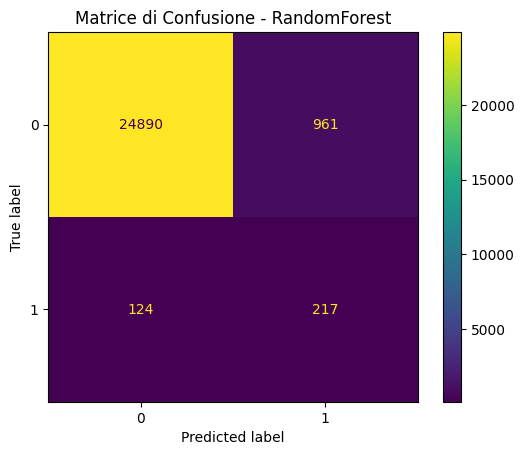

In [21]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from imblearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


X = merged_dataset['testo_combinato_preprocessed'].fillna("")  # Riempie eventuali NaN con stringhe vuote
y = merged_dataset['positivi']

# Loop per ogni classificatore
for clf_name, clf in classifiers.items():
    print(f"\n### Modello: {clf_name} ###")
    
    # Configura il pipeline con Wcbtfidf e il classificatore
    pipeline = Pipeline([
        #('tfidf_icf', TfidfIcfVectorizer(max_features=5000)),  # Imposta max_features; verifica se è sufficiente per il dataset
        #('tfidf_rf', TfidfRfVectorizer(max_features=5000)),
        ('tfidf_igm', TfidfIgmVectorizer(max_features=5000)),
        #('smote', SMOTE(random_state=42)),
        ('smote', SMOTE(random_state=42, sampling_strategy= 0.1 )),  # Applica SMOTE prima per la classe minoritaria
        ('undersample', RandomUnderSampler(sampling_strategy= 'auto', random_state=42)),  # Poi undersampling della classe maggioritaria
        ('classificazione', clf)
    ])

    # Esegui la cross-validation
    df_avg, auc_avg, f1_avg_per_class, num_features_avg = eval_cross_validation(pipeline, X, y, skf)

    # Stampa i risultati
    print("Classification report mediato:")
    print(df_avg)
    print(f"AUC medio: {auc_avg:.4f}")
    print(f"Numero medio di features: {num_features_avg:.2f}")
    
    # Previsioni su tutto il dataset usando cross_val_predict
    y_pred = cross_val_predict(pipeline, X, y, cv=skf)

    # Visualizza la matrice di confusione
    ConfusionMatrixDisplay.from_predictions(y, y_pred)
    plt.title(f"Matrice di Confusione - {clf_name}")
    plt.show()


In [ ]:
##########################################################################

In [46]:
########################### CROSS VALIDATION #########################

from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_predict
import numpy as np


# Funzione modificata per includere la media delle features
def eval_cross_validation(pipeline, X, y, skf):
    list_reports = []
    list_f1 = []
    list_auc = []  # Lista per raccogliere i valori di AUC mediati
    list_num_features = []  # Lista per raccogliere il numero di features per ogni fold
    
    # Crea una lista per raccogliere precision, recall e f1-score mediati
    precision_sum = {}
    recall_sum = {}
    f1_sum = {}
    
    # Liste per la deviazione standard
    precision_values = {}
    recall_values = {}
    f1_values = {}

    # Inizializza il supporto per ogni classe
    unique_labels = y.unique()
    support_sum = {str(label): 0 for label in unique_labels}  # Assicurati che le etichette siano stringhe

    for train, val in skf.split(X, y):
        X_tr = X.values[train]
        y_tr = y.values[train]
        X_val = X.values[val]
        y_val = y.values[val]

        # Addestra il pipeline sul training set
        pipeline.fit(X_tr, y_tr)

        # Previsioni sul validation set
        y_pred = pipeline.predict(X_val)
        y_pred_prob = pipeline.predict_proba(X_val)[:, 1]  # Probabilità della classe positiva

        # Crea il classification report come dizionario
        cr = classification_report(y_val, y_pred, output_dict=True)

        # Aggiungi il report alla lista
        list_reports.append(cr)

        # Estrai il F1-score
        list_f1.append(cr['weighted avg']['f1-score'])

        # Calcola l'AUC per questo fold
        auc_score = roc_auc_score(y_val, y_pred_prob)
        list_auc.append(auc_score)

        # Raccogli il numero di features per questo fold
        X_tfidf = pipeline.named_steps['tfidf'].transform(X_val)
        list_num_features.append(X_tfidf.shape[1])  # Numero di features per questo fold

        # Somma le metriche per ogni classe
        for label, metrics in cr.items():
            if label not in ['accuracy', 'macro avg', 'weighted avg']:
                precision_sum[label] = precision_sum.get(label, 0) + metrics['precision']
                recall_sum[label] = recall_sum.get(label, 0) + metrics['recall']
                f1_sum[label] = f1_sum.get(label, 0) + metrics['f1-score']

                # Aggiungi valori per la deviazione standard
                precision_values[label] = precision_values.get(label, []) + [metrics['precision']]
                recall_values[label] = recall_values.get(label, []) + [metrics['recall']]
                f1_values[label] = f1_values.get(label, []) + [metrics['f1-score']]

                # Somma il supporto per questa fold
                support_sum[str(label)] += metrics['support']  # Usa str(label) per garantire la corrispondenza

    # Calcola la media dell'AUC
    auc_avg = np.mean(list_auc)

    # Calcola la media del numero di features
    num_features_avg = np.mean(list_num_features)

    # Calcola la media delle metriche per ogni classe
    num_folds = skf.get_n_splits()
    precision_avg = {label: precision_sum[label] / num_folds for label in precision_sum}
    recall_avg = {label: recall_sum[label] / num_folds for label in recall_sum}
    f1_avg_per_class = {label: f1_sum[label] / num_folds for label in f1_sum}

    # Calcola la deviazione standard per ogni metrica
    precision_std = {label: np.std(precision_values[label]) for label in precision_values}
    recall_std = {label: np.std(recall_values[label]) for label in recall_values}
    f1_std = {label: np.std(f1_values[label]) for label in f1_values}

    # Calcola il supporto medio per ciascuna classe
    support_avg = {label: support_sum[label] / num_folds for label in support_sum}

    # Crea un DataFrame per visualizzare le metriche
    df_avg = pd.DataFrame({
        'Precision': precision_avg,
        'Recall': recall_avg,
        'F1-Score': f1_avg_per_class,
        'Precision Std': precision_std,
        'Recall Std': recall_std,
        'F1-Score Std': f1_std,
        'Support': support_avg,  # Supporto medio
        'Avg Features': num_features_avg,  # Media delle features
    })  # Trasponi per avere le classi come righe

    return df_avg, auc_avg, f1_avg_per_class, num_features_avg 

# Crea un oggetto StratifiedKFold per la cross-validation stratificata
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


### Modello: LogisticRegression ###
Dimensione della matrice TF-IDF: 26192 campioni, 129716 features


/home/v.acampora/venv2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/v.acampora/venv2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/v.acampora/venv2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report mediato:
   Precision    Recall  F1-Score  Precision Std  Recall Std  F1-Score Std  \
0   0.987464  0.999458  0.993425       0.000409    0.000495      0.000383   
1   0.445000  0.038067  0.069732       0.377863    0.032250      0.058877   

   Support  Avg Features  
0   2585.1      122451.6  
1     34.1      122451.6  
AUC medio: 0.9528
Numero medio di features: 122451.60


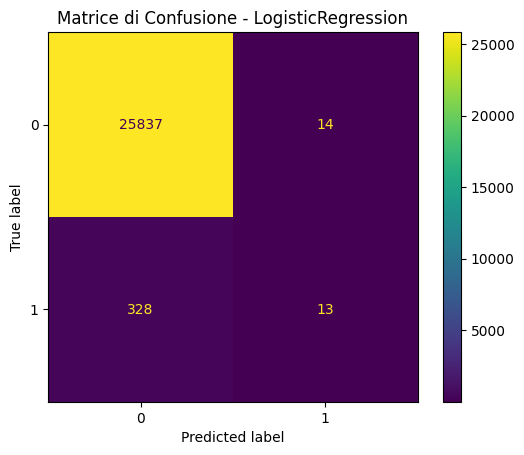

In [47]:
##################### CLASSIFICATION SENZA MAX FEATURES E SENZA SMOTE ############################

from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Esegui la cross-validation per ogni classificatore
#X = merged_dataset['testo_combinato_preprocessed'].fillna("").astype(str)
X = merged_dataset['testo_combinato_preprocessed']
y = merged_dataset['positivi']

for clf_name, clf in classifiers.items():
    print(f"\n### Modello: {clf_name} ###")
    
    # Crea la pipeline per il classificatore corrente
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),  #VETTORIZZAZIONE SENZA MAX FEATURES
        ('classificazione', clf)
    ])

    # Fit the pipeline to the data
    pipeline.fit(X, y)

    # Trasforma i dati e ottieni la matrice TF-IDF
    X_tfidf = pipeline.named_steps['tfidf'].transform(X)

    # Ottieni la dimensione della matrice TF-IDF
    num_samples, num_features = X_tfidf.shape
    print(f"Dimensione della matrice TF-IDF: {num_samples} campioni, {num_features} features")

    # Calcola le metriche usando la funzione
    df_avg, auc_avg, f1_avg_per_class, num_features_avg = eval_cross_validation(pipeline, X, y, skf)

    # Stampa i risultati
    print("Classification report mediato:")

    print(df_avg)
    print(f"AUC medio: {auc_avg:.4f}")
    print(f"Numero medio di features: {num_features_avg:.2f}")
    
    # Previsioni su tutto il dataset usando cross_val_predict
    y_pred = cross_val_predict(pipeline, X, y, cv=skf)

    
    # Visualizza la matrice di confusione
    ConfusionMatrixDisplay.from_predictions(y, y_pred)
    plt.title(f"Matrice di Confusione - {clf_name}")
    plt.show()


In [ ]:
########################### per stampare le probabilità delle classi ###################

# Calcola le probabilità delle classi
y_proba = cross_val_predict(pipeline, X, y, cv=skf, method='predict_proba')

# Predici le classi con soglia 0.5
y_pred = (y_proba[:, 1] >= 0.5).astype(int)

# Identifica gli esempi in cui il modello sbaglia
error_indices = np.where(y_pred != y)[0]

# Analizza le probabilità per i campioni sbagliati
print(f"Numero di errori: {len(error_indices)}")
print("Probabilità degli errori:")
for idx in error_indices[:10]:  # Mostra solo i primi 10 errori per brevità
    print(f"Esempio {idx}: Classe reale: {y[idx]}, Predetta: {y_pred[idx]}, "
          f"Probabilità Classe 0: {y_proba[idx, 0]:.4f}, Classe 1: {y_proba[idx, 1]:.4f}")

# Calcola la differenza assoluta tra le probabilità delle due classi per gli errori
proba_diff = np.abs(y_proba[error_indices, 0] - y_proba[error_indices, 1])

# Mostra un'analisi delle differenze di probabilità per gli errori
print("\nAnalisi differenze probabilità degli errori:")
print(f"Media differenza probabilità: {proba_diff.mean():.4f}")
print(f"Minima differenza probabilità: {proba_diff.min():.4f}")
print(f"Massima differenza probabilità: {proba_diff.max():.4f}")


Numero di errori: 342
Probabilità degli errori:
Esempio 110: Classe reale: 1, Predetta: 0, Probabilità Classe 0: 0.9115, Classe 1: 0.0885
Esempio 123: Classe reale: 1, Predetta: 0, Probabilità Classe 0: 0.8995, Classe 1: 0.1005
Esempio 127: Classe reale: 1, Predetta: 0, Probabilità Classe 0: 0.6336, Classe 1: 0.3664
Esempio 139: Classe reale: 1, Predetta: 0, Probabilità Classe 0: 0.6529, Classe 1: 0.3471
Esempio 160: Classe reale: 1, Predetta: 0, Probabilità Classe 0: 0.8904, Classe 1: 0.1096
Esempio 212: Classe reale: 1, Predetta: 0, Probabilità Classe 0: 0.8353, Classe 1: 0.1647
Esempio 234: Classe reale: 1, Predetta: 0, Probabilità Classe 0: 0.7761, Classe 1: 0.2239
Esempio 251: Classe reale: 1, Predetta: 0, Probabilità Classe 0: 0.6479, Classe 1: 0.3521
Esempio 318: Classe reale: 1, Predetta: 0, Probabilità Classe 0: 0.7650, Classe 1: 0.2350
Esempio 374: Classe reale: 1, Predetta: 0, Probabilità Classe 0: 0.9621, Classe 1: 0.0379

Analisi differenze probabilità degli errori:
Media 

In [ ]:
############################################################


### Modello: RandomForest ###

Fold 1 - Training Metrics
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23265
           1       1.00      1.00      1.00       307

    accuracy                           1.00     23572
   macro avg       1.00      1.00      1.00     23572
weighted avg       1.00      1.00      1.00     23572

Fold 1 - Test Metrics
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2586
           1       0.00      0.00      1.00        34

    accuracy                           0.99      2620
   macro avg       0.49      0.50      1.00      2620
weighted avg       0.97      0.99      0.99      2620



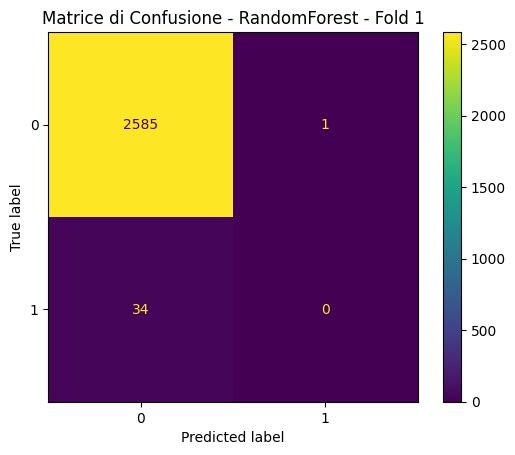


Fold 2 - Training Metrics
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23266
           1       1.00      1.00      1.00       306

    accuracy                           1.00     23572
   macro avg       1.00      1.00      1.00     23572
weighted avg       1.00      1.00      1.00     23572

Fold 2 - Test Metrics
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2585
           1       1.00      0.00      0.00        35

    accuracy                           0.99      2620
   macro avg       0.99      0.50      0.50      2620
weighted avg       0.99      0.99      0.98      2620



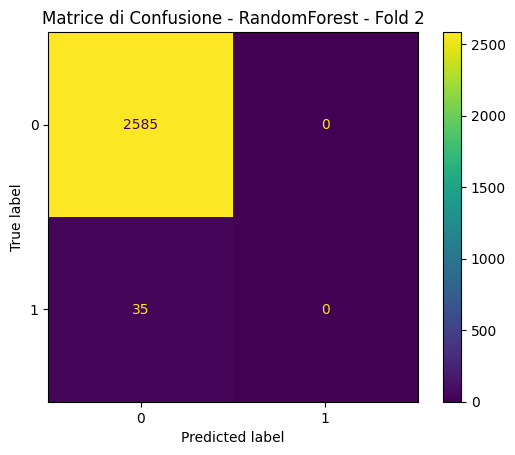


Fold 3 - Training Metrics
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23266
           1       1.00      1.00      1.00       307

    accuracy                           1.00     23573
   macro avg       1.00      1.00      1.00     23573
weighted avg       1.00      1.00      1.00     23573

Fold 3 - Test Metrics
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2585
           1       0.60      0.09      0.15        34

    accuracy                           0.99      2619
   macro avg       0.79      0.54      0.57      2619
weighted avg       0.98      0.99      0.98      2619



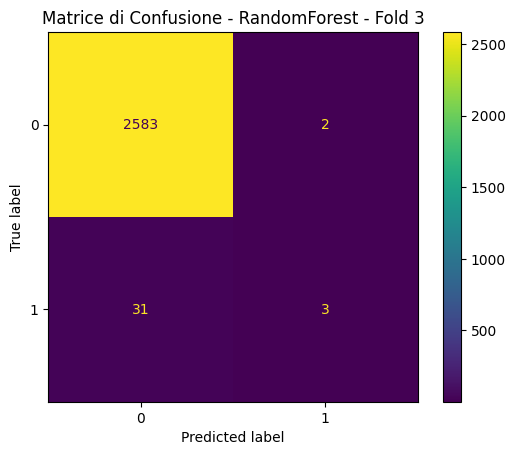


Fold 4 - Training Metrics
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23266
           1       1.00      1.00      1.00       307

    accuracy                           1.00     23573
   macro avg       1.00      1.00      1.00     23573
weighted avg       1.00      1.00      1.00     23573

Fold 4 - Test Metrics
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2585
           1       0.00      0.00      1.00        34

    accuracy                           0.99      2619
   macro avg       0.49      0.50      1.00      2619
weighted avg       0.97      0.99      0.99      2619



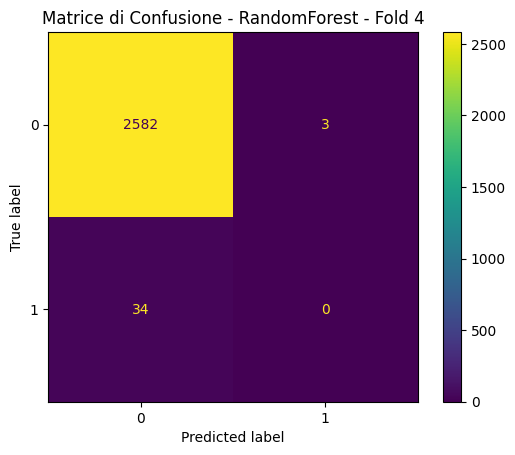


Fold 5 - Training Metrics
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23266
           1       1.00      1.00      1.00       307

    accuracy                           1.00     23573
   macro avg       1.00      1.00      1.00     23573
weighted avg       1.00      1.00      1.00     23573

Fold 5 - Test Metrics
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2585
           1       0.50      0.03      0.06        34

    accuracy                           0.99      2619
   macro avg       0.74      0.51      0.52      2619
weighted avg       0.98      0.99      0.98      2619



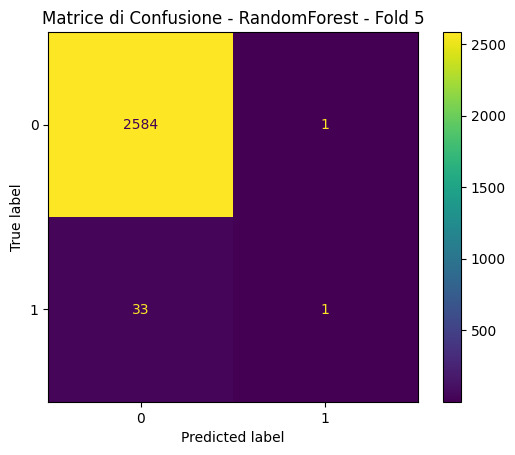


Fold 6 - Training Metrics
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23266
           1       1.00      1.00      1.00       307

    accuracy                           1.00     23573
   macro avg       1.00      1.00      1.00     23573
weighted avg       1.00      1.00      1.00     23573

Fold 6 - Test Metrics
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2585
           1       0.00      0.00      1.00        34

    accuracy                           0.99      2619
   macro avg       0.49      0.50      1.00      2619
weighted avg       0.97      0.99      0.99      2619



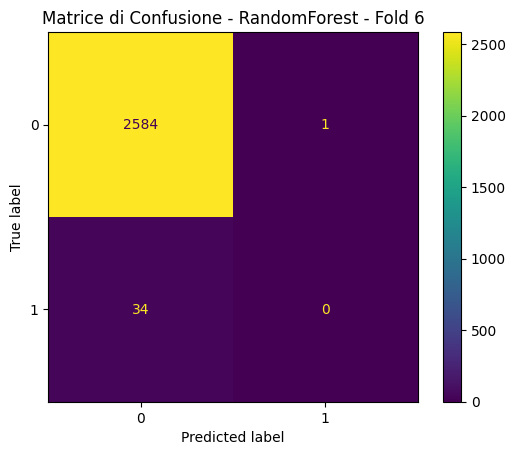


Fold 7 - Training Metrics
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23266
           1       1.00      1.00      1.00       307

    accuracy                           1.00     23573
   macro avg       1.00      1.00      1.00     23573
weighted avg       1.00      1.00      1.00     23573

Fold 7 - Test Metrics
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2585
           1       1.00      0.00      0.00        34

    accuracy                           0.99      2619
   macro avg       0.99      0.50      0.50      2619
weighted avg       0.99      0.99      0.98      2619



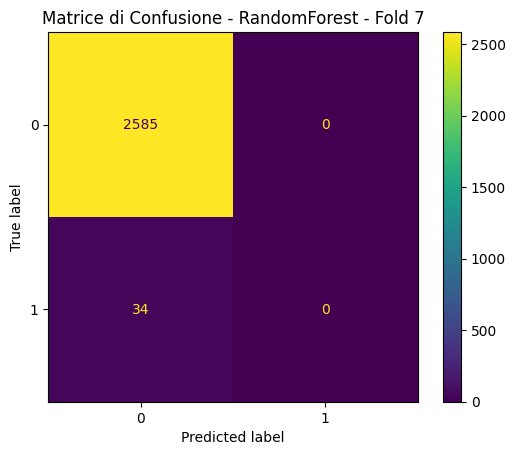


Fold 8 - Training Metrics
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23266
           1       1.00      1.00      1.00       307

    accuracy                           1.00     23573
   macro avg       1.00      1.00      1.00     23573
weighted avg       1.00      1.00      1.00     23573

Fold 8 - Test Metrics
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2585
           1       0.00      0.00      1.00        34

    accuracy                           0.99      2619
   macro avg       0.49      0.50      1.00      2619
weighted avg       0.97      0.99      0.99      2619



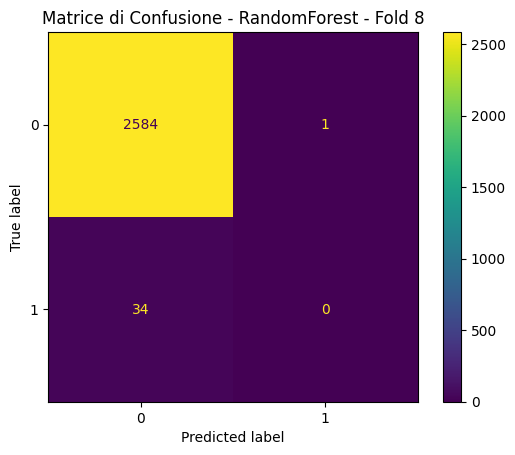


Fold 9 - Training Metrics
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23266
           1       1.00      1.00      1.00       307

    accuracy                           1.00     23573
   macro avg       1.00      1.00      1.00     23573
weighted avg       1.00      1.00      1.00     23573

Fold 9 - Test Metrics
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2585
           1       1.00      0.00      0.00        34

    accuracy                           0.99      2619
   macro avg       0.99      0.50      0.50      2619
weighted avg       0.99      0.99      0.98      2619



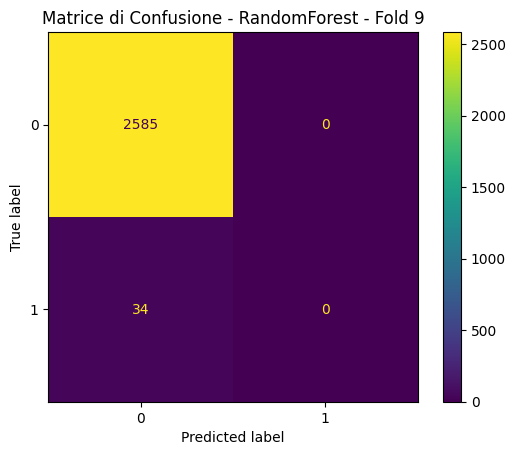


Fold 10 - Training Metrics
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23266
           1       1.00      1.00      1.00       307

    accuracy                           1.00     23573
   macro avg       1.00      1.00      1.00     23573
weighted avg       1.00      1.00      1.00     23573

Fold 10 - Test Metrics
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2585
           1       0.50      0.03      0.06        34

    accuracy                           0.99      2619
   macro avg       0.74      0.51      0.52      2619
weighted avg       0.98      0.99      0.98      2619



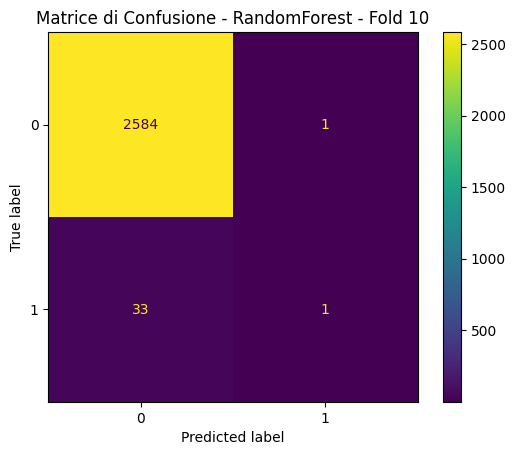


### Risultati Medi - RandomForest ###
F1 Macro Medio (Training): 1.0000
F1 Macro Medio (Validation): 0.7099


In [ ]:
##################### VALUTAZIONE SUL TRAINING CHE MOSTRA UNA SITUAZIONE DI OVERFITTING NEL RF ############################
# ho provato senza max features e con e senza smote (senza max depth): il risultato è praticamente lo stesso

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt

# Esegui la cross-validation per ogni classificatore
X = merged_dataset['testo_combinato_preprocessed']
y = merged_dataset['positivi']

for clf_name, clf in classifiers.items():
    print(f"\n### Modello: {clf_name} ###")
    
    # Crea la pipeline per il classificatore corrente
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),  # Vettorizzazione senza max features
        ('smote', SMOTE(random_state=42)), 
        ('classificazione', clf)
    ])

    # Inizializza StratifiedKFold
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    training_scores = []
    validation_scores = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        # Dividi i dati
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Addestra il modello sul training set
        pipeline.fit(X_train, y_train)

        # Previsioni sul training set
        y_train_pred = pipeline.predict(X_train)

        # Previsioni sul test set
        y_test_pred = pipeline.predict(X_test)

        # Calcola le metriche sul training set
        train_report = classification_report(y_train, y_train_pred, output_dict=True, zero_division=1)
        training_scores.append(train_report['macro avg']['f1-score'])

        # Calcola le metriche sul test set
        test_report = classification_report(y_test, y_test_pred, output_dict=True, zero_division=1)
        validation_scores.append(test_report['macro avg']['f1-score'])

        # Stampa le performance per il fold corrente
        print(f"\nFold {fold} - Training Metrics")
        print(classification_report(y_train, y_train_pred, zero_division=1))
        print(f"Fold {fold} - Test Metrics")
        print(classification_report(y_test, y_test_pred, zero_division=1))

        # Matrice di confusione per il fold corrente (opzionale)
        ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
        plt.title(f"Matrice di Confusione - {clf_name} - Fold {fold}")
        plt.show()

    # Calcola e stampa le performance medie
    print(f"\n### Risultati Medi - {clf_name} ###")
    print(f"F1 Macro Medio (Training): {np.mean(training_scores):.4f}")
    print(f"F1 Macro Medio (Validation): {np.mean(validation_scores):.4f}")


In [ ]:
###################### grid search per max_features ############################
################### con f1 ottengo None ma con auc ottengo 0.1 #######################à

from sklearn.model_selection import GridSearchCV

X = merged_dataset['testo_combinato_preprocessed']
y = merged_dataset['positivi']
# Trasforma i dati con TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X)

# Definisci il classificatore Random Forest
rf = RandomForestClassifier(random_state=42,n_jobs=-1)

# Griglia dei valori di max_features
param_grid = {
    'max_features': ['sqrt', 'log2', 0.1, 0.2, 0.5, None]
}

# Esegui GridSearchCV sulla Random Forest
grid_search = GridSearchCV(
    rf,
    param_grid,
    cv=skf,  # Usa StratifiedKFold
    scoring='f1',  # Valutazione tramite AUC
    n_jobs=-1
)

# Esegui la ricerca
grid_search.fit(X_tfidf, y)

# Ottieni il miglior parametro e il miglior modello
best_max_features = grid_search.best_params_['max_features']
print(f"Miglior valore per max_features: {best_max_features}")

Miglior valore per max_features: None


In [ ]:
#######################################################


### Modello: RandomForest ###


Dimensione della matrice TF-IDF: 26192 campioni, 129716 features
Classification report mediato:
   Precision    Recall  F1-Score  Precision Std  Recall Std  F1-Score Std  \
0   0.990300  0.987080  0.988685       0.001078    0.001980      0.000938   
1   0.210995  0.266807  0.234412       0.052559    0.083427      0.064422   

   Support  Avg Features  
0   2585.1      122451.6  
1     34.1      122451.6  
AUC medio: 0.8987
Numero medio di features: 122451.60


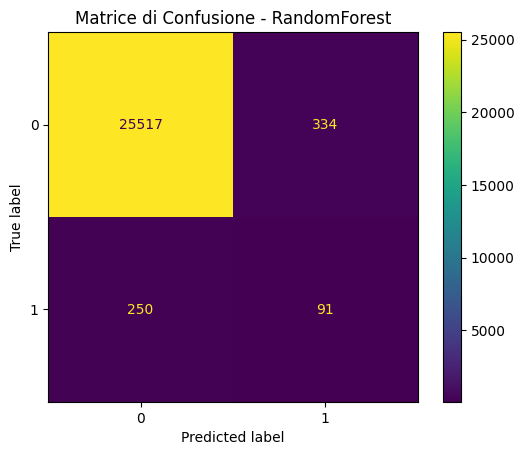

In [18]:
##################### CLASSIFICATION SENZA MAX FEATURES ############################

from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Esegui la cross-validation per ogni classificatore
#X = merged_dataset['testo_combinato_preprocessed'].fillna("").astype(str)
X = merged_dataset['testo_combinato_preprocessed']
y = merged_dataset['positivi']

for clf_name, clf in classifiers.items():
    print(f"\n### Modello: {clf_name} ###")
    
    # Crea la pipeline per il classificatore corrente
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),  #VETTORIZZAZIONE SENZA MAX FEATURES
        ('smote', SMOTE(random_state=42)), 
        ('classificazione', clf)
    ])

    # Fit the pipeline to the data
    pipeline.fit(X, y)

    # Trasforma i dati e ottieni la matrice TF-IDF
    X_tfidf = pipeline.named_steps['tfidf'].transform(X)

    # Ottieni la dimensione della matrice TF-IDF
    num_samples, num_features = X_tfidf.shape
    print(f"Dimensione della matrice TF-IDF: {num_samples} campioni, {num_features} features")

    # Calcola le metriche usando la funzione
    df_avg, auc_avg, f1_avg_per_class, num_features_avg = eval_cross_validation(pipeline, X, y, skf)

    # Stampa i risultati
    print("Classification report mediato:")
    print(df_avg)
    print(f"AUC medio: {auc_avg:.4f}")
    print(f"Numero medio di features: {num_features_avg:.2f}")
    
    # Previsioni su tutto il dataset usando cross_val_predict
    y_pred = cross_val_predict(pipeline, X, y, cv=skf)

    # Visualizza la matrice di confusione
    ConfusionMatrixDisplay.from_predictions(y, y_pred)
    plt.title(f"Matrice di Confusione - {clf_name}")
    plt.show()



### Modello: RandomForest ###
Dimensione della matrice TF-IDF: 26192 campioni, 5000 features
Classification report mediato:
   Precision    Recall  F1-Score  Precision Std  Recall Std  F1-Score Std  \
0   0.992651  0.987389  0.990012       0.000836    0.002105      0.001156   
1   0.320440  0.445630  0.371578       0.049026    0.064481      0.051975   

   Support  Avg Features  
0   2585.1        5000.0  
1     34.1        5000.0  
AUC medio: 0.9426
Numero medio di features: 5000.00


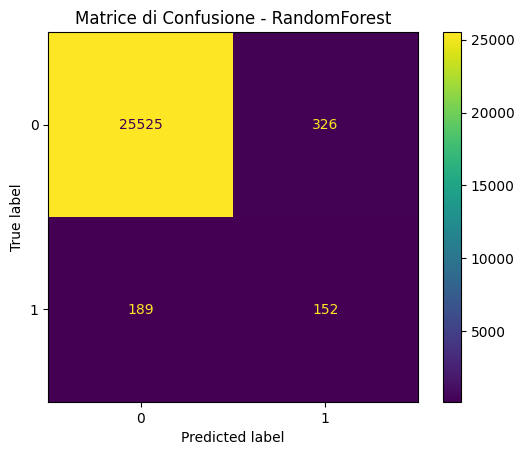

In [20]:
########################## CLASSIFICATION CON MAX FEATURES 5000 ###############################

from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Esegui la cross-validation per ogni classificatore
#X = merged_dataset['testo_combinato_preprocessed'].fillna("").astype(str)
X = merged_dataset['testo_combinato_preprocessed']
y = merged_dataset['positivi']

for clf_name, clf in classifiers.items():
    print(f"\n### Modello: {clf_name} ###")
    
    # Crea la pipeline per il classificatore corrente
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000)),  #VETTORIZZAZIONE CON MAX FEATURES=5000
        ('smote', SMOTE(random_state=42)), 
        ('classificazione', clf)
    ])

    # Fit the pipeline to the data
    pipeline.fit(X, y)

    # Trasforma i dati e ottieni la matrice TF-IDF
    X_tfidf = pipeline.named_steps['tfidf'].transform(X)

    # Ottieni la dimensione della matrice TF-IDF
    num_samples, num_features = X_tfidf.shape
    print(f"Dimensione della matrice TF-IDF: {num_samples} campioni, {num_features} features")

    # Calcola le metriche usando la funzione
    df_avg, auc_avg, f1_avg_per_class, num_features_avg  = eval_cross_validation(pipeline, X, y, skf)

    # Stampa i risultati
    print("Classification report mediato:")
    print(df_avg)
    print(f"AUC medio: {auc_avg:.4f}")
    print(f"Numero medio di features: {num_features_avg:.2f}")

    # Previsioni su tutto il dataset usando cross_val_predict
    y_pred = cross_val_predict(pipeline, X, y, cv=skf)

    # Visualizza la matrice di confusione
    ConfusionMatrixDisplay.from_predictions(y, y_pred)
    plt.title(f"Matrice di Confusione - {clf_name}")
    plt.show()


In [31]:
#######################################################

In [18]:
# --- Estrazione e interpretazione dei coefficienti (solo per la regressione logistica) ---
if 'logisticregression' in clf_name.lower():  # Verifica che il classificatore sia una regressione logistica
    model = pipeline.named_steps['classificazione']
        
    # Estrai il vocabolario del TfidfVectorizer
    tfidf_vectorizer = pipeline.named_steps['tfidf']
    vocab = tfidf_vectorizer.get_feature_names_out()

    # Estrai i coefficienti della regressione logistica
    coefficients = model.coef_.flatten()  # Appiattisci per lavorare con un array 1D
        
    # Associa i coefficienti con le parole
    feature_importance = pd.DataFrame({
        'word': vocab,
        'coefficient': coefficients
    })
        
    # Ordina le parole in base al valore assoluto del coefficiente (importanza)
    feature_importance = feature_importance.reindex(feature_importance['coefficient'].abs().sort_values(ascending=False).index)
        
    # Visualizza le prime 10 parole più influenti (positivamente e negativamente)
    print("\nTop 10 feature più influenti (in base al coefficiente):")
    print(feature_importance.head(20))

    print("\nBottom 10 feature meno influenti (in base al coefficiente):")
    print(feature_importance.tail(20))


Top 10 feature più influenti (in base al coefficiente):
              word  coefficient
1206     deiscenza    12.349563
2239     infezione    10.178145
1832        ferito     7.673894
3760      raccolta     6.524024
252    antibiotico     5.981351
3731     purulento     5.755687
907      colturale     5.672706
2708     materiale     5.140437
1831        ferita     5.058935
908      colturali     4.913687
2371  iperpiressia     4.700911
1705         esito     4.691795
2786         mezzo     4.493662
786     chirurgico     4.438724
3895     revisione     4.304890
4469        stomia     4.115594
3974     rimozione     3.905425
2880       moncone     3.840862
4380       sparing     3.795510
481        bactrim     3.787976

Bottom 10 feature meno influenti (in base al coefficiente):
                word  coefficient
2580          lingua     0.003036
20          accedeva    -0.002922
1297      dilatativo     0.002870
683           cardio    -0.002556
2927        multipli    -0.002515
2626  

In [ ]:
########################################

Distribuzione delle classi originale:
(array([0, 1]), array([25851,   341]))

### Modello: RandomForest ###
Dimensione della matrice TF-IDF: 26192 campioni, 5000 features

Dopo SMOTE:
(array([0, 1]), array([25851,  2585]))
Dopo undersampling:
(array([0, 1]), array([2585, 2585]))
Classification report mediato:
   Precision    Recall  F1-Score  Precision Std  Recall Std  F1-Score Std  \
0   0.995046  0.962826  0.978663       0.001234    0.004885      0.002456   
1   0.185384  0.635966  0.286399       0.027302    0.092288      0.039259   

   Support  Avg Features  
0   2585.1        5000.0  
1     34.1        5000.0  
AUC medio: 0.9488
Numero medio di features: 5000.00


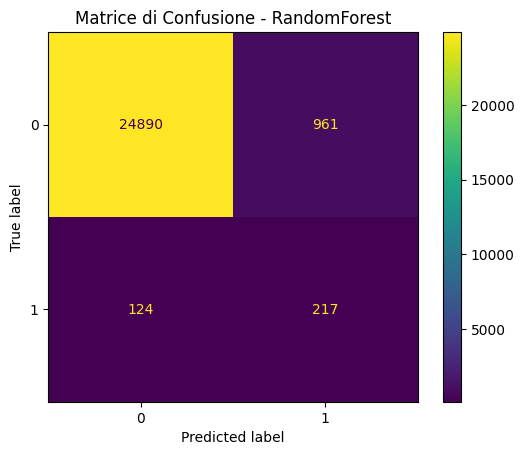

In [21]:
#################### SMOTE + UNDERSAMPLING CON MAX FEATURES ##########################

from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Esegui la cross-validation per ogni classificatore
#X = merged_dataset['testo_combinato_preprocessed'].fillna("").astype(str)
X = merged_dataset['testo_combinato_preprocessed']
y = merged_dataset['positivi']

# Stampa la distribuzione delle classi originale
print("Distribuzione delle classi originale:")
print(np.unique(y, return_counts=True))

for clf_name, clf in classifiers.items():
    print(f"\n### Modello: {clf_name} ###")
    
    # Crea la pipeline per il classificatore corrente
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000)),  # Vettorizzazione con max_features=5000
        ('smote', SMOTE(random_state=42, sampling_strategy= 0.1 )),  # Applica SMOTE prima per la classe minoritaria
        ('undersample', RandomUnderSampler(sampling_strategy= 'auto', random_state=42)),  # Poi undersampling della classe maggioritaria
        ('classificazione', clf)
    ])

    # Applica solo il vettorizzatore per ottenere la matrice TF-IDF e stamparne le dimensioni
    X_tfidf = pipeline.named_steps['tfidf'].fit_transform(X)
    num_samples, num_features = X_tfidf.shape
    print(f"Dimensione della matrice TF-IDF: {num_samples} campioni, {num_features} features")

    # Bilanciamento delle classi: applica SMOTE e undersampling separatamente e stampa la distribuzione delle classi
    print("\nDopo SMOTE:")
    X_smote, y_smote = SMOTE(random_state=42, sampling_strategy= 0.1 ).fit_resample(X_tfidf, y)
    print(np.unique(y_smote, return_counts=True))

    print("Dopo undersampling:")
    X_resampled, y_resampled = RandomUnderSampler(sampling_strategy= 'auto', random_state=42).fit_resample(X_smote, y_smote)
    print(np.unique(y_resampled, return_counts=True))

    
    # Calcola le metriche usando la cross-validation
    df_avg, auc_avg, f1_avg_per_class, num_features_avg = eval_cross_validation(pipeline, X, y, skf)

    # Stampa i risultati
    print("Classification report mediato:")
    print(df_avg)
    print(f"AUC medio: {auc_avg:.4f}")
    print(f"Numero medio di features: {num_features_avg:.2f}")

    # Previsioni su tutto il dataset usando cross_val_predict
    y_pred = cross_val_predict(pipeline, X, y, cv=skf)

    # Visualizza la matrice di confusione
    ConfusionMatrixDisplay.from_predictions(y, y_pred)
    plt.title(f"Matrice di Confusione - {clf_name}")
    plt.show()
